In [10]:
import h5py
import matplotlib.pyplot as plt
from   matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import pandas as pd
import re

# Preliminary

In [2]:
# Define the base directory containing the data
DATA_DIR = '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/'

# List of valid bar letters (e.g., 'A', 'B', ..., 'J')
BAR_LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

# Initialize an empty list to store directories corresponding to bars
BAR_DIRECTORIES = []

# Traverse the directory structure recursively using os.walk
for root, dirs, files in os.walk(DATA_DIR):

        # Extract the bar letter (parent directory name) and bar number (current directory name)
        bar_letter = os.path.basename(os.path.dirname(root))
        bar_number = os.path.basename(root)

        # Check if the directory matches the expected pattern:
        # - The parent directory name (bar_letter) is in the list of valid bar letters
        # - The current directory name (bar_number) is a digit
        if bar_letter in BAR_LETTERS and bar_number.isdigit():
            BAR_DIRECTORIES.append(root)

# Sort the directories: alphabetically by bar_letter & numerically by bar_number
BAR_DIRECTORIES.sort()

In [36]:
def COMPUTE_RATE_FILE(FILE_PATH):
    """
    Helper function to calculate the event rate from a single HDF5 file.

    This function reads an HDF5 file containing event data, computes the event rate 
    (events per second), and calculates the associated error. The event rate is 
    determined based on the timestamps of the events in the file.

    Parameters:
    -----------
    FILE_PATH : str
        Path to the HDF5 file containing the event data.

    Returns:
    --------
    tuple
        A tuple containing:
        - Rate_CV (float): The calculated event rate (events per second).
        - Rate_Err (float): The error in the calculated event rate.
        If the time difference is invalid or an error occurs, returns (-1, -1).
    """
    # HDF5 key to access the data
    h5_key = 'data'

    try:
        # Read the HDF5 file into a DataFrame
        data_df = pd.read_hdf(FILE_PATH, key=h5_key)

        # Check if the DataFrame is not empty and contains the 'timestamp' column
        if not data_df.empty and 'timestamp' in data_df.columns:
                
            # Sort the DataFrame by timestamp to ensure correct chronological order
            data_df = data_df.sort_values(by='timestamp').reset_index(drop=True)
            
            # Extract the first and last timestamps
            first_timestamp = data_df['timestamp'].iloc[0]
            last_timestamp = data_df['timestamp'].iloc[-1]
            
            time_difference = (last_timestamp - first_timestamp) * 0.001        # in [s]

            # Calculate the event count and its error
            evt_CV = len(data_df)
            evt_err = np.sqrt(evt_CV)

            # Ensure the time difference is valid before calculating the rate
            if time_difference > 0:
                Rate_CV  = evt_CV / time_difference
                Rate_Err = evt_err / time_difference

                return Rate_CV, Rate_Err
            else:
                # Invalid time difference, return error values
                return -1, -1

    # Handle specific errors
    except KeyError:
        print(f"Warning: HDF5 key '{h5_key}' not found in file {FILE_PATH}. Skipping this file.")
    except Exception as e:
        print(f"An error occurred while processing {FILE_PATH}: {e}")

    # Return error values in case of failure
    return -1, -1

def PLOT_CHARGE_HIST_FILE(FILE_PATH, PLOT_LABEL, SIGNAL_CHANNELS=[6, 7], X_LIMITS=[0, 2000]):
    """
    Helper function to plot the charge histogram from a single HDF5 file.

    This function reads charge data from an HDF5 file and generates a histogram 
    for the charge distribution of specified channels. The histogram includes 
    a control/noise channel and two active signal channels. The function also 
    allows setting custom x-axis limits for the histogram.

    Parameters:
    -----------
    FILE_PATH : str
        Path to the HDF5 file containing the charge data.
    PLOT_LABEL : str
        Label for the plot title, typically describing the dataset or file.
    SIGNAL_CHANNELS : list of int, optional
        List of two integers specifying the indices of the active signal channels 
        to be plotted. Default is [6, 7].
    X_LIMITS : list of int, optional
        List of two integers specifying the x-axis limits for the histogram. 
        Default is [0, 2000].

    Returns:
    --------
    None
        The function generates and displays a histogram plot. It does not return any value.
    """
    try:
        # Open the HDF5 file in read mode
        with h5py.File(FILE_PATH, "r") as f:

            # Check if the 'charges' dataset exists in the file
            if 'charges' not in f:
                print(f"Warning: 'charges' dataset not found in {FILE_PATH}.")
                return

            # Read the 'charges' dataset into a NumPy array
            charges_df = f["charges"][:]
                
            # Extract charge data for the control/noise channel and the two signal channels
            charge_control = charges_df[:, 5]
            charge_signal_1 = charges_df[:, SIGNAL_CHANNELS[0]]
            charge_signal_2 = charges_df[:, SIGNAL_CHANNELS[1]]  # Second signal channel

            # ----- Plotting ----- #
            # Define histogram bins with a fixed width of 10 ADC counts
            bins = np.arange(X_LIMITS[0], X_LIMITS[1] + 10, 10)

            # Set the plot style
            plt.style.use('ggplot')
            plt.figure(figsize=(10, 6))    
            
            # Plot histograms for each channel
            plt.hist(charge_control,  bins=bins, histtype='step', color='red',   linewidth=1.0, alpha=1.0, label='Noise')
            plt.hist(charge_signal_1, bins=bins, histtype='step', color='blue',  linewidth=1.0, alpha=1.0, label=f'Channel {SIGNAL_CHANNELS[0]} (Active)')
            plt.hist(charge_signal_2, bins=bins, histtype='step', color='green', linewidth=1.0, alpha=1.0, label=f'Channel {SIGNAL_CHANNELS[1]} (Active)')

            # Add labels, title, and legend
            plt.xlabel('Charge (ADC)')
            plt.xlim(X_LIMITS)
            plt.ylabel('Counts')
            plt.yscale('log')
            plt.legend()
            plt.title(f'{PLOT_LABEL}')
            
            # Add grid and adjust layout
            plt.grid(True, which='both', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        # Handle any exceptions that occur during file reading or plotting
        print(f"An error occurred while processing {FILE_PATH}: {e}")

# Event Rates

First, process your data and store them into a DataFrame.

In [4]:
BAR_DIRECTORIES

['/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/1',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/2',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/3',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/4',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/5',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/6',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/7',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/1',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/2',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/3',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/4',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/5',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/6',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/7',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/C/1',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/C/2',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/C/3',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/C/4',
 '/lhome/i

In [5]:
# Global

# DataFrame to store rates information
Rates_df = pd.DataFrame()

# Process each bar directory in sorted order
for dir_path in BAR_DIRECTORIES:

        bar_letter = os.path.basename(os.path.dirname(dir_path))
        bar_number = os.path.basename(dir_path)

        print(f"--- Processing Bar {bar_letter}{bar_number} ---")

        h5_files = sorted(
                                [f for f in os.listdir(dir_path) if f.endswith('.h5')],
                                key=lambda x: int(re.search(r'\d+', x).group())
                        )

        for file in h5_files:

                # Run information
                h5_path = os.path.join(dir_path, file)
                run_id = int(re.search(r'\d+', file).group())
                run_type = 'NO Source' if run_id % 2 != 0 else 'With Source'

                print(f"Processing file: {h5_path}")
                print(f"   Run ID: {run_id}, Run Type: {run_type}")

                # Rate
                Rate_CV, Rate_Err = COMPUTE_RATE_FILE(h5_path)
                # print(f'Rate = {Rate_CV:.2f} +/- {Rate_Err:.2f} Hz')

                # Store information
                Rates_df = pd.concat([Rates_df, pd.DataFrame({
                                                                'Bar_Label': [f'{bar_letter}{bar_number}'],
                                                                'Run_ID': [run_id], 
                                                                'Rate_CV': [Rate_CV], 
                                                                'Rate_Err': [Rate_Err],
                                                                'Run_Type': [run_type]
                                                            })], ignore_index=True)

--- Processing Bar A1 ---
Processing file: /lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/1/muons_run_1.h5
   Run ID: 1, Run Type: NO Source
Processing file: /lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/1/muons_run_2.h5
   Run ID: 2, Run Type: With Source
--- Processing Bar A2 ---
Processing file: /lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/2/muons_run_3.h5
   Run ID: 3, Run Type: NO Source
Processing file: /lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/2/muons_run_4.h5
   Run ID: 4, Run Type: With Source
--- Processing Bar A3 ---
Processing file: /lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/3/muons_run_5.h5
   Run ID: 5, Run Type: NO Source
Processing file: /lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/3/muons_run_6.h5
   Run ID: 6, Run Type: With Source
--- Processing Bar A4 ---
Processing file: /lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/4/muons_run_1.h5
   Run ID: 1, Run Type: NO Source
Processing file: /lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/4/muo

In [6]:
Rates_df

,Bar_Label,Run_ID,Rate_CV,Rate_Err,Run_Type
0,A1,1,27.149277,0.170933,NO Source
1,A1,2,161.062525,0.944490,With Source
2,A2,3,14.674280,0.092834,NO Source
3,A2,4,86.765922,0.526338,With Source
4,A3,5,-1.000000,-1.000000,NO Source
...,...,...,...,...,...
133,J5,132,107.191966,0.662323,With Source
134,J6,133,20.767168,0.131451,NO Source
135,J6,134,52.705119,0.331781,With Source
136,J7,135,21.077171,0.133354,NO Source


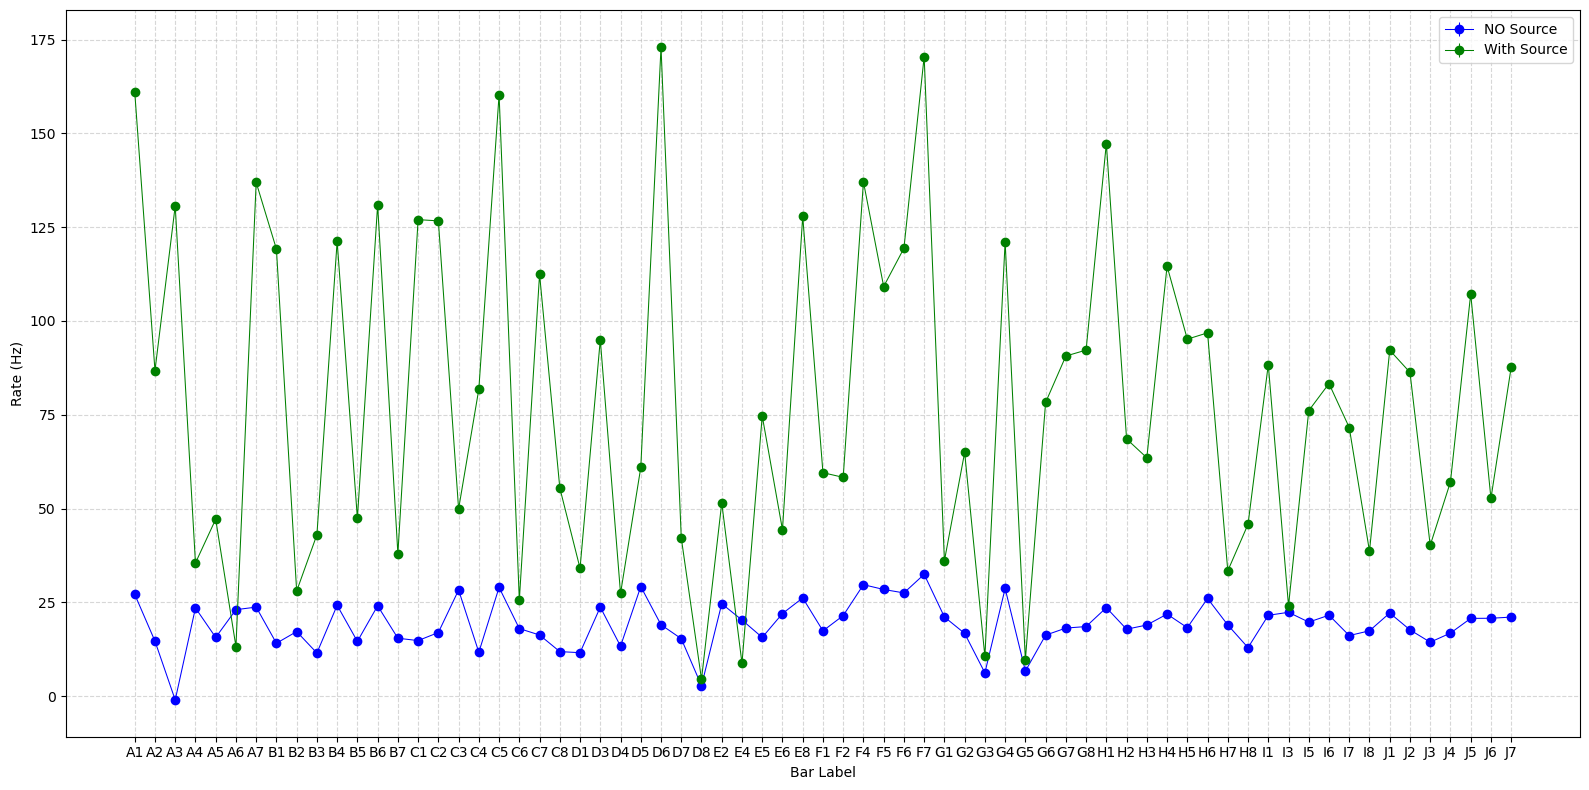

In [8]:
# ----- Rate ----- #
# Dataframes filtered
no_source_df   = Rates_df[Rates_df['Run_Type'] == 'NO Source']
with_source_df = Rates_df[Rates_df['Run_Type'] == 'With Source']

# ----- Plotting ----- #
plt.figure(figsize=(16, 8))

# NO Source
plt.errorbar(no_source_df['Bar_Label'], no_source_df['Rate_CV'], yerr=no_source_df['Rate_Err'], fmt='o-', lw=0.75, label='NO Source', color='blue')
# With Source
plt.errorbar(with_source_df['Bar_Label'], with_source_df['Rate_CV'], yerr=with_source_df['Rate_Err'], fmt='o-', lw=0.75, label='With Source', color='green')

# ----- Styling ----- #
plt.xlabel('Bar Label')
plt.xticks(sorted(Rates_df['Bar_Label'].unique()))
plt.ylabel('Rate (Hz)')
# plt.ylim(0, 180)
plt.legend()

plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Single Bar

In [9]:
BAR_DIRECTORIES

['/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/1',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/2',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/3',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/4',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/5',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/6',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/7',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/1',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/2',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/3',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/4',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/5',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/6',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/B/7',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/C/1',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/C/2',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/C/3',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/C/4',
 '/lhome/i

In [44]:
def ANALYZE_SINGLE_BAR(DIR_PATH, SIGNAL_CHANNELS=[6,7], X_LIMITS=[0, 2000]):
    """
    Analyzes a single muon veto bar by plotting its event rates and charge distributions
    for runs with and without a source.

    Args:
        bar_directory_path (str): The full path to the directory containing a bar's data files.
                                  (e.g., ".../data/A/1")
    """
    # Bar information
    bar_letter = os.path.basename(os.path.dirname(dir_path))
    bar_number = os.path.basename(dir_path)
    bar_label = f"{bar_letter}{bar_number}"

    h5_files = sorted(
                            [f for f in os.listdir(DIR_PATH) if f.endswith('.h5')],
                            key=lambda x: int(re.search(r'\d+', x).group())
                     )

    for file in h5_files:

        # Run information
        print(f"  File: {file}")
        h5_path = os.path.join(DIR_PATH, file)
        run_id   = int(re.search(r'\d+', file).group())
        run_type = 'NO Source' if run_id % 2 != 0 else 'With Source'

        # Rate
        Rate_CV, Rate_Err = COMPUTE_RATE_FILE(h5_path)
        print(f'  Rate = ({Rate_CV:.2f} ± {Rate_Err:.2f}) Hz || {run_type}')

        # Charge histograms
        label = f'Bar {bar_label} ({run_type}) ||  Rate = ({Rate_CV:.2f} ± {Rate_Err:.2f}) Hz'
        PLOT_CHARGE_HIST_FILE(h5_path, label, SIGNAL_CHANNELS=SIGNAL_CHANNELS, X_LIMITS=X_LIMITS)


--- Processing Bar A3 ---
  File: muons_run_5.h5
  Rate = (-1.00 ± -1.00) Hz || NO Source


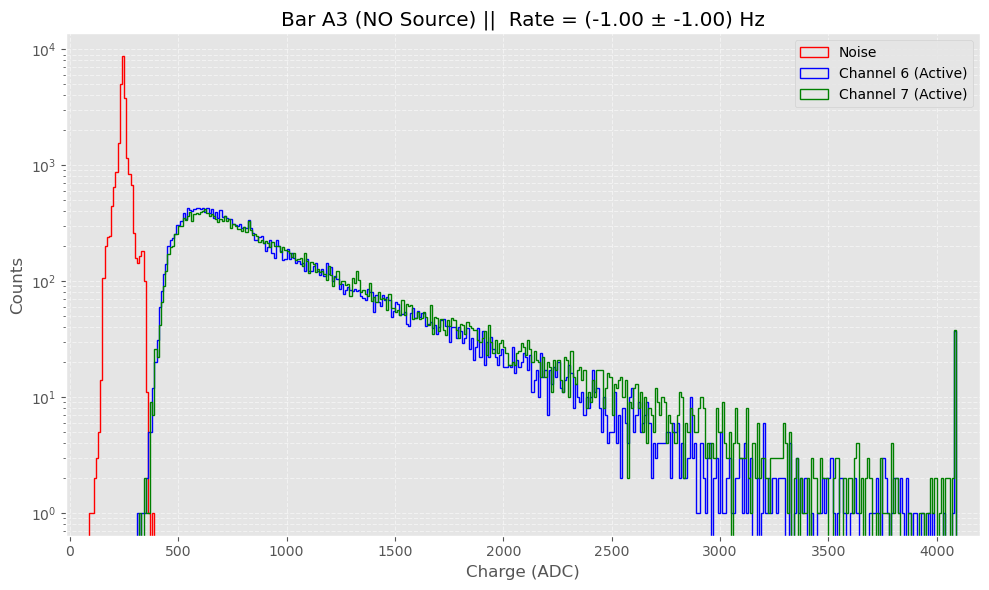

  File: muons_run_6.h5
  Rate = (130.65 ± 0.78) Hz || With Source


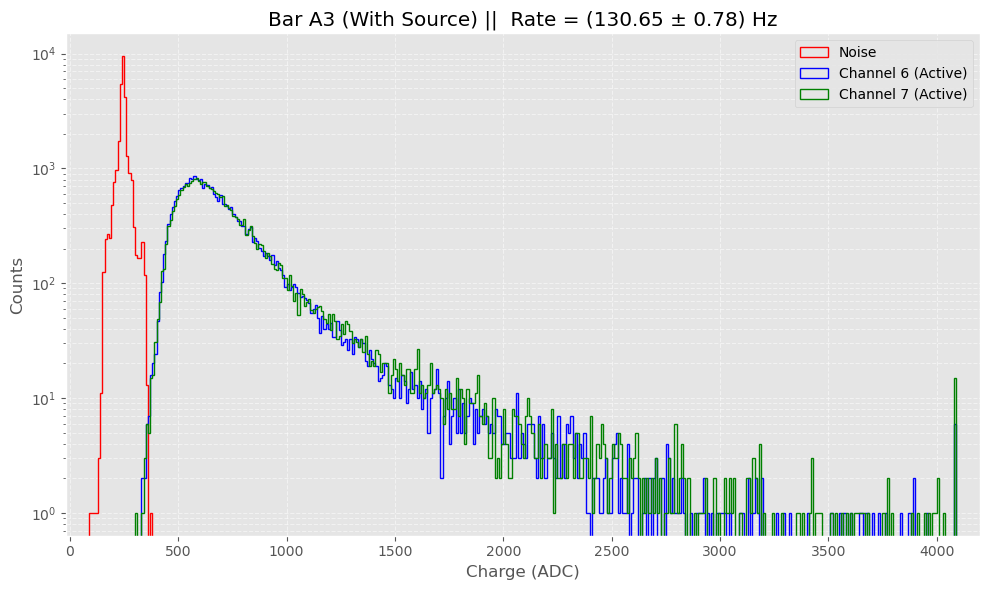


--- Processing Bar A6 ---
  File: muons_run_5.h5
  Rate = (23.06 ± 0.14) Hz || NO Source


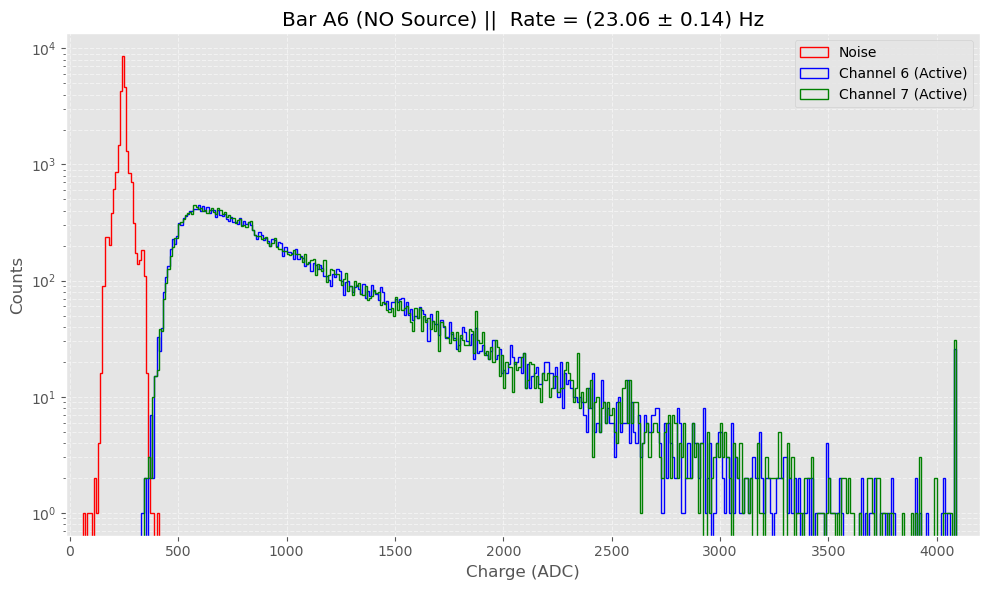

  File: muons_run_6.h5
  Rate = (13.24 ± 0.08) Hz || With Source


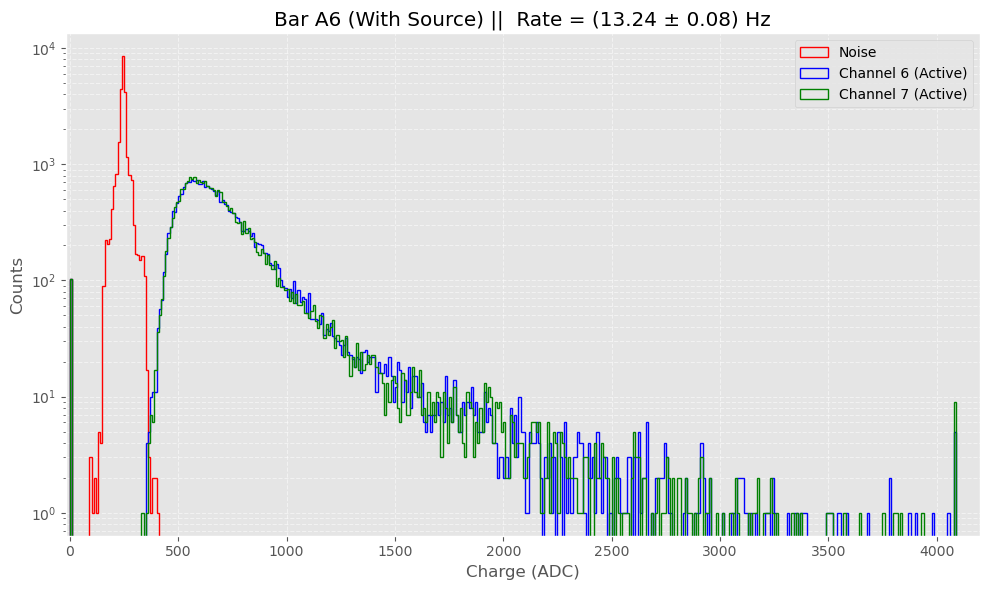


--- Processing Bar D8 ---
  File: muons_run_51.h5
  Rate = (2.80 ± 0.02) Hz || NO Source


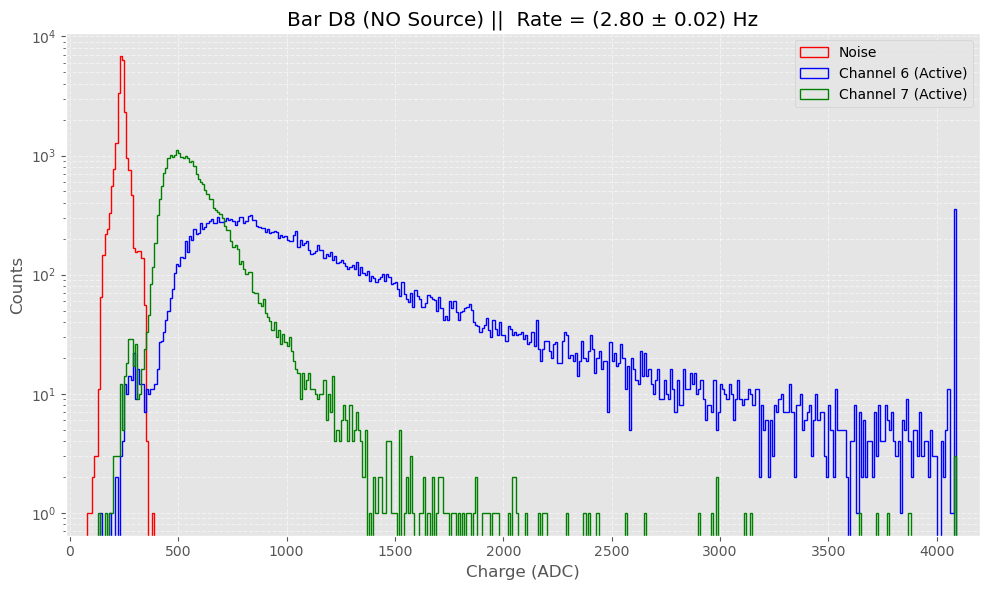

  File: muons_run_52.h5
  Rate = (4.51 ± 0.03) Hz || With Source


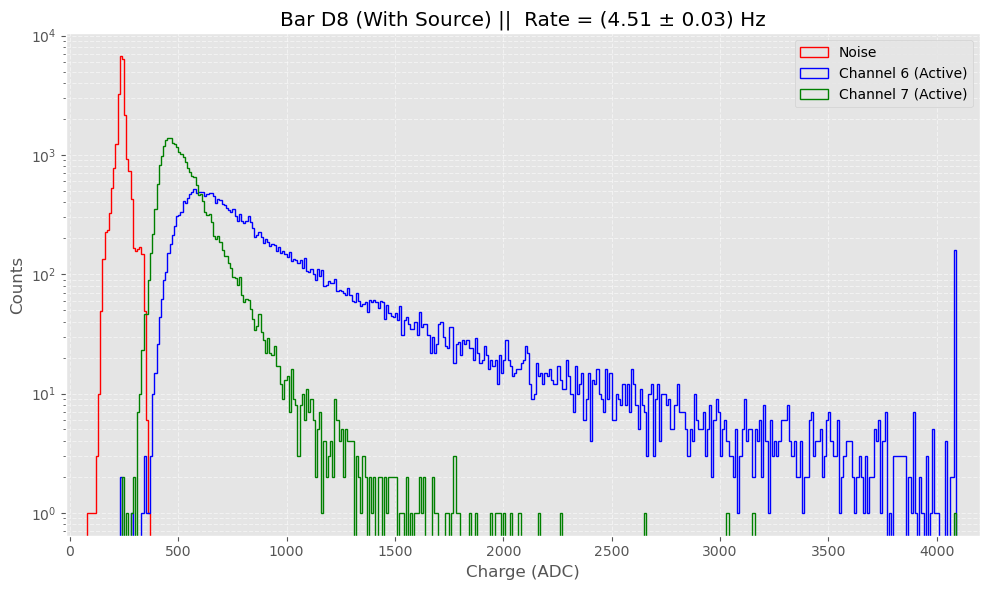


--- Processing Bar E4 ---
  File: muons_run_57.h5
  Rate = (20.30 ± 0.13) Hz || NO Source


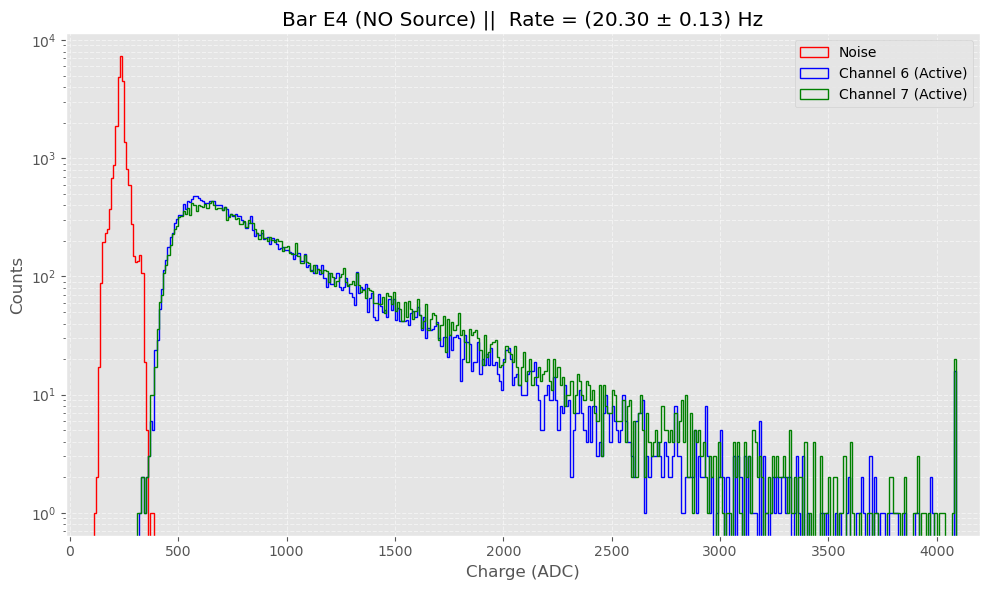

  File: muons_run_58.h5
  Rate = (8.76 ± 0.06) Hz || With Source


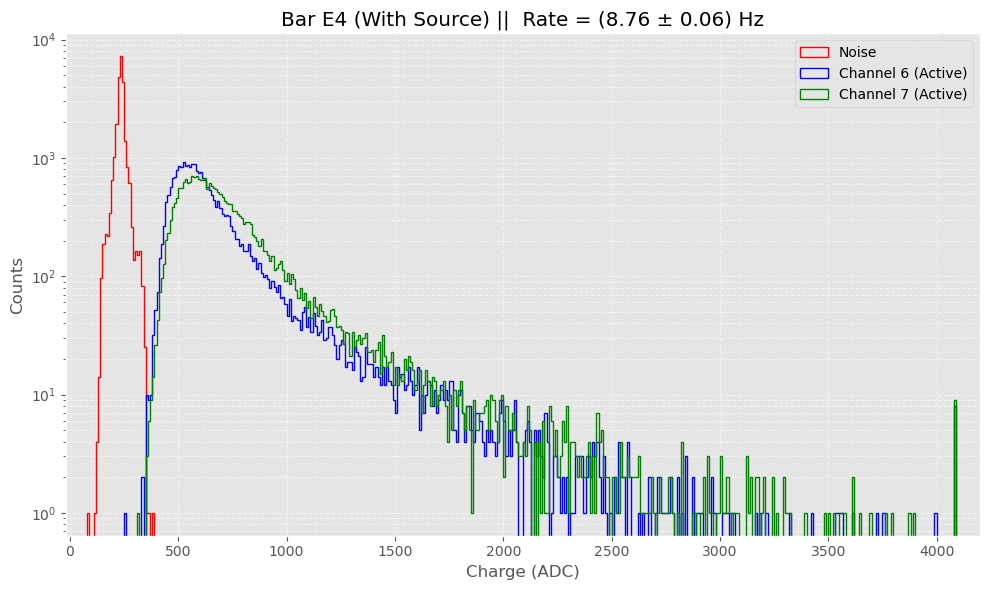


--- Processing Bar G3 ---
  File: muons_run_81.h5
  Rate = (6.22 ± 0.10) Hz || NO Source


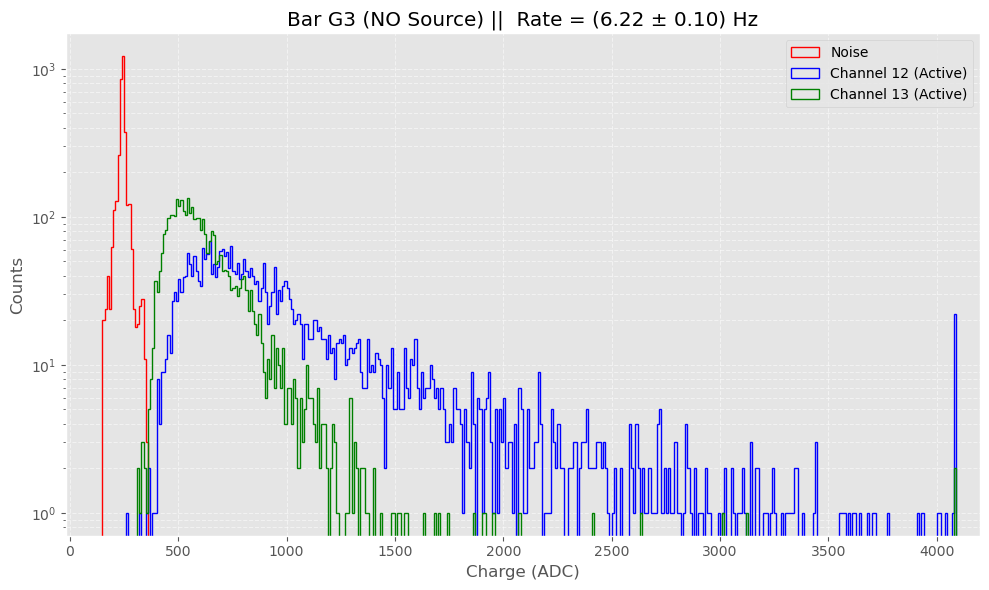

  File: muons_run_82.h5
  Rate = (10.58 ± 0.15) Hz || With Source


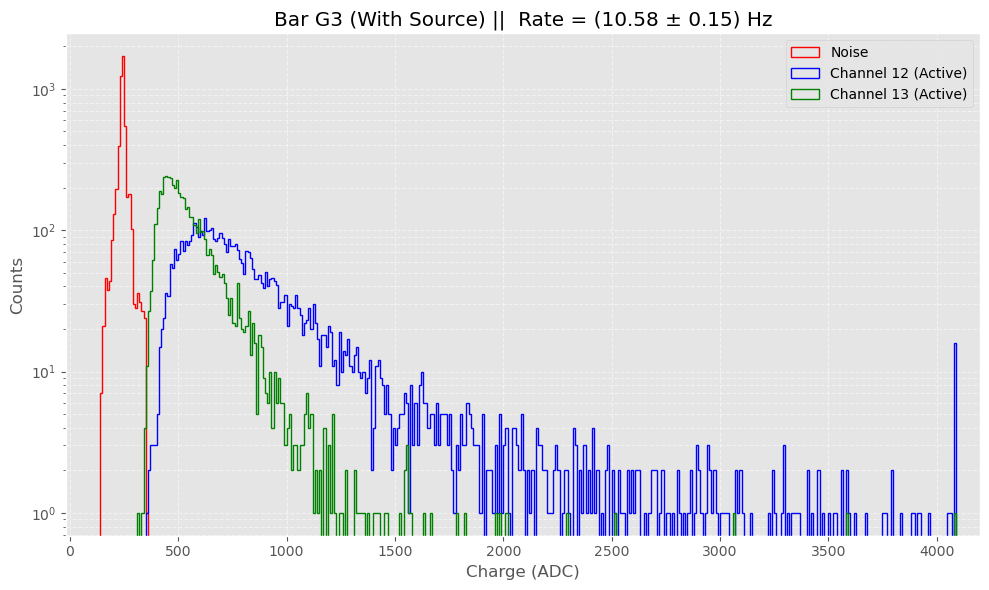


--- Processing Bar G5 ---
  File: muons_run_85.h5
  Rate = (6.69 ± 0.13) Hz || NO Source


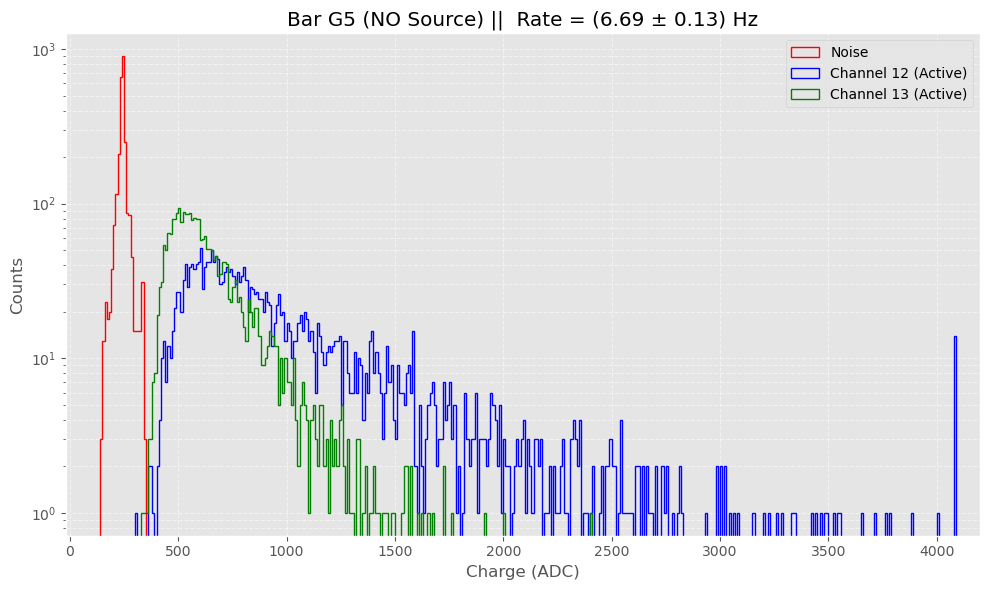

  File: muons_run_86.h5
  Rate = (9.69 ± 0.14) Hz || With Source


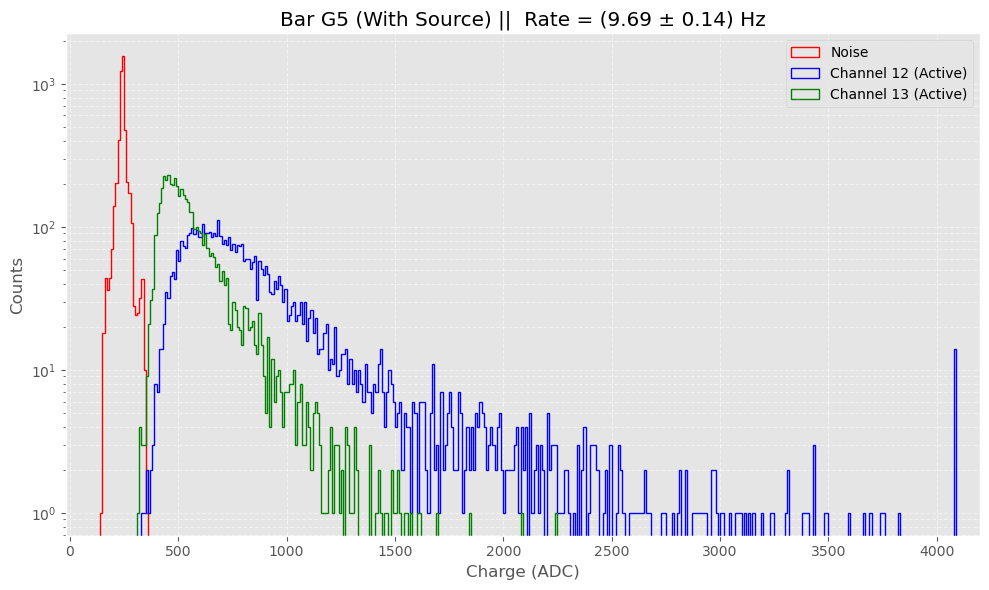


--- Processing Bar H7 ---
  File: muons_run_105.h5
  Rate = (18.98 ± 0.12) Hz || NO Source


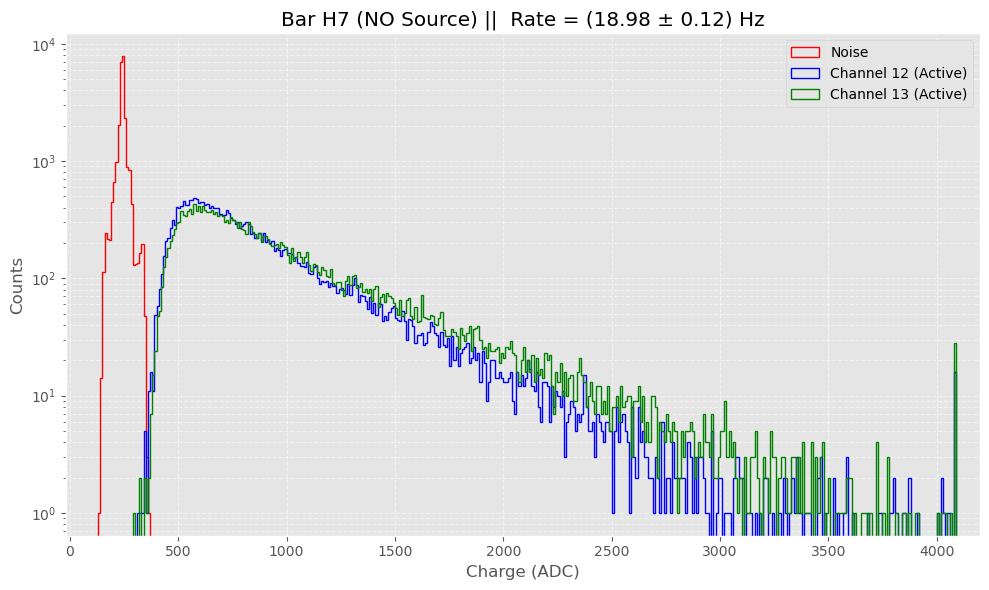

  File: muons_run_106.h5
  Rate = (33.41 ± 0.21) Hz || With Source


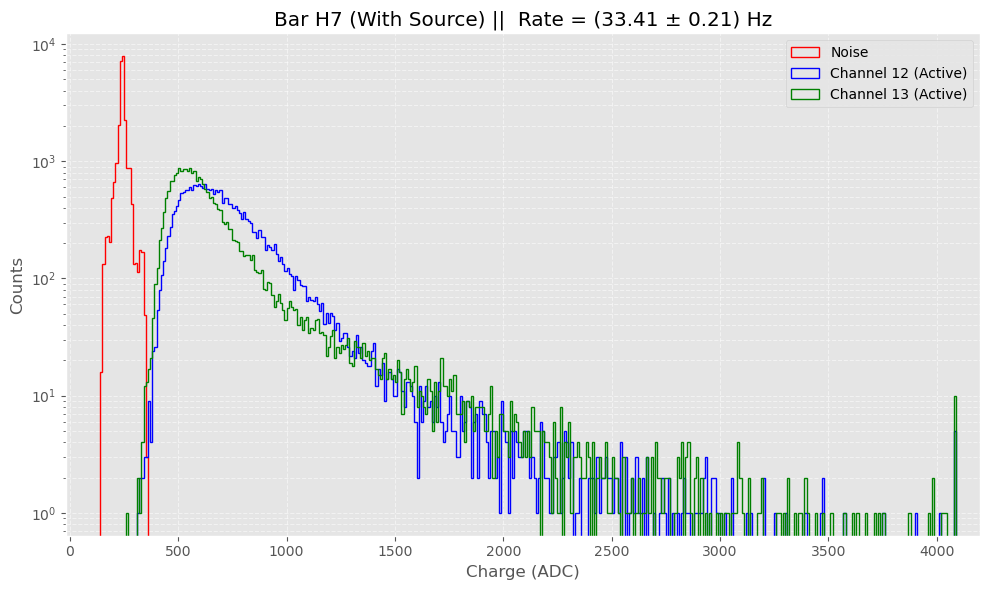


--- Processing Bar I3 ---
  File: muons_run_113.h5
  Rate = (22.35 ± 0.14) Hz || NO Source


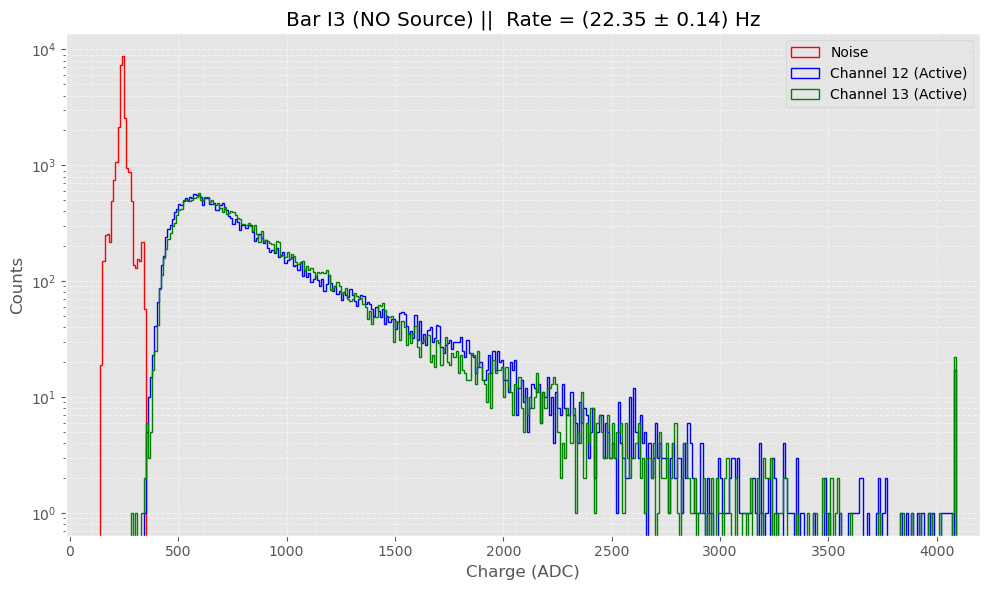

  File: muons_run_114.h5
  Rate = (24.10 ± 0.15) Hz || With Source


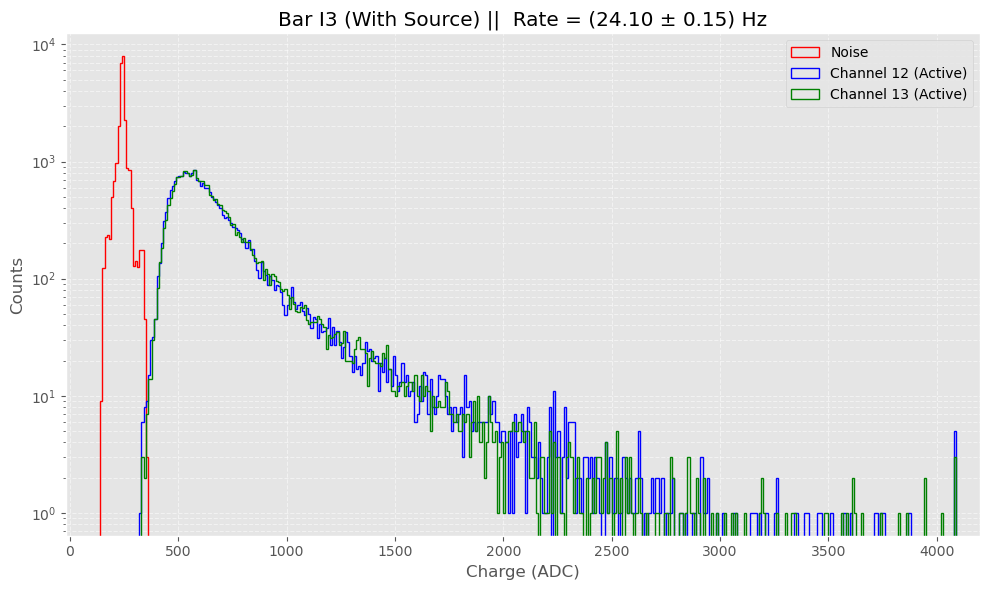


--- Processing Bar J7 ---
  File: muons_run_135.h5
  Rate = (21.08 ± 0.13) Hz || NO Source


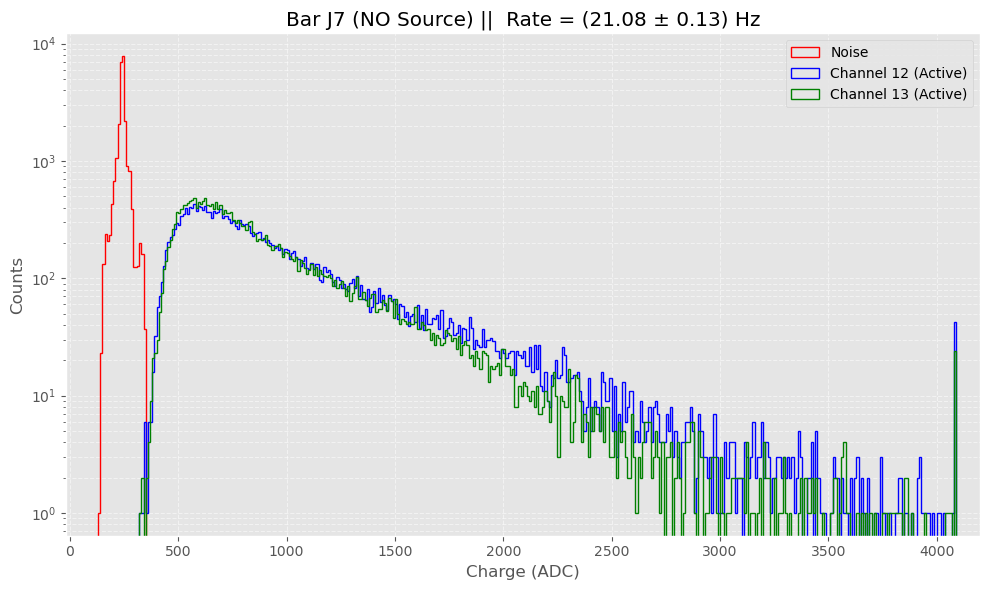

  File: muons_run_136.h5
  Rate = (87.66 ± 0.55) Hz || With Source


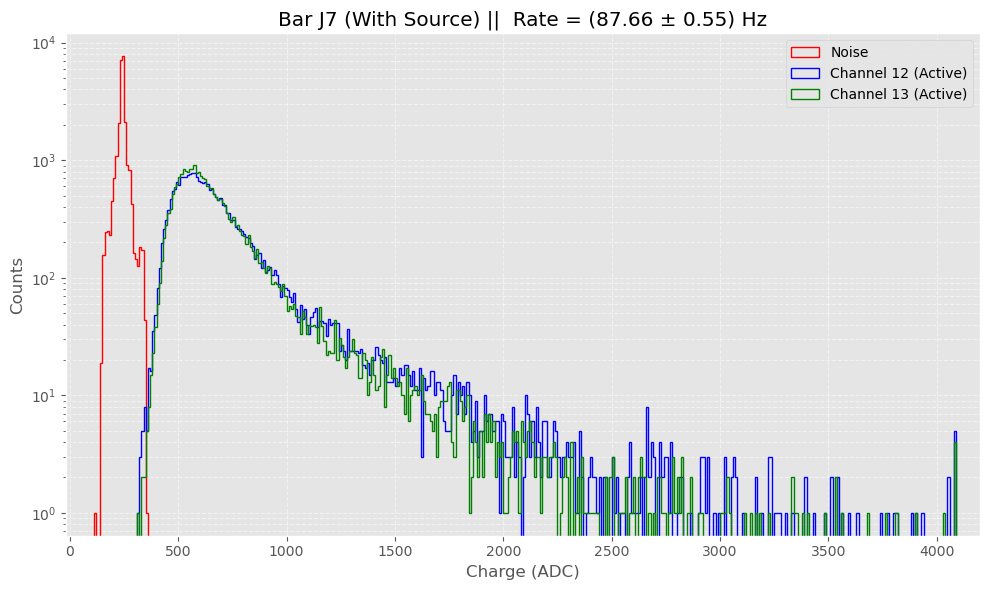

In [47]:
SEL_BAR_LABEL = ["A3", "A6", "D8", "E4", "G3", "G5", "I3", "H7", "J7"]
CHANNELS = [6, 7]          # Channels to plot
X_LIMITS = [-20, 4.2e3]        # X-axis limits for charge histogram

# Process each bar directory in sorted order
for dir_path in BAR_DIRECTORIES:

        # Bar information
        bar_letter = os.path.basename(os.path.dirname(dir_path))
        bar_number = os.path.basename(dir_path)
        bar_label = f"{bar_letter}{bar_number}"

        if bar_label not in SEL_BAR_LABEL:
                continue

        print(f"\n--- Processing Bar {bar_label} ---")

        if bar_label in ["G3", "G5", "I3", "H7", "J7"]:
            ANALYZE_SINGLE_BAR(dir_path, SIGNAL_CHANNELS=[12,13], X_LIMITS=X_LIMITS)

        else:
            ANALYZE_SINGLE_BAR(dir_path, SIGNAL_CHANNELS=CHANNELS, X_LIMITS=X_LIMITS)

## A3 WTF?

In [50]:
BAR_DIRECTORIES[:3]

['/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/1',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/2',
 '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/A/3']